# Correlation between pairwise prediction error similarities and pairwise predicted expression similarities

Supplemental analysis motivating the stratified grouping by showing that cells with similar predicted expression tend to also have similar prediction errors.

It relies on the outputs of `spatial_conformal_uncertainty.py` followed by `get_calibration.py` applied to all eleven benchmark dataset pairs. In particular, it requires running the Python commands in all the job scripts of form: `run_conformal_{i}.slurm`. The h5ad anndata objects should be saved into "scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/" with respect to the current working directory (or an alternative path for stratified grouping results).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cosine
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from TISSUE.tissue.main import *
from TISSUE.tissue.utils import *

In [2]:
# Dataset mapping between keys and detailed descriptor
dataset_mapper = {"Dataset3": "Mouse Hipp. (seqFISH)",
                  "Dataset9": "Mouse VISP (MERFISH)",
                  "Dataset11": "Mouse PC (STARmap)", 
                  "Dataset12": "Human MTG (ISS)",
                  "Dataset13": "Mouse VISP (ISS)",
                  "Dataset14": "Drosophila Embryo (FISH)",
                  "Dataset15": "Mouse SC (osmFISH)",
                  "Dataset17": "Mouse VISP (ExSeq)",
                  "Axolotl": "Axolotl Brain (Stereo-seq)",
                  "Dataset7": "Human U2OS (MERFISH)",
                  "Dataset1": "Mouse Gast. (seqFISH)"}

In [3]:
def get_correlation_between_error_corr_and_expression_corr (adata, keys=None, mode="cells"):
    '''
    Takes in adata (AnnData) and returns correlation between pairwise error correlation and gene expression correlation
    
    keys = list of keys in adata.obsm to report correlations for; if None will use all of them with "predicted_expression"
    '''
    r_list = []
    
    if keys == None:
        keys = [x for x in list(adata.obsm.keys()) if "predicted_expression" in x]

    for model in keys:
        
        # predicted expression correlation
        expression_mat = adata.obsm[model]
        if mode == "cell":
            cor_exp = np.corrcoef(expression_mat).flatten()
        elif mode == "gene":
            cor_exp = np.corrcoef(expression_mat.T).flatten()
        
        # prediction error correlation
        error_mat = adata.obsm[model]-adata.X
        if mode == "cell":
            cor_err = np.corrcoef(error_mat).flatten()
        elif mode == "gene":
            cor_err = np.corrcoef(error_mat.T).flatten()
        
        # mask out nans
        good = ~np.logical_or(np.isnan(cor_exp), np.isnan(cor_err))
        
        # correlation of correlations
        r,p=pearsonr(cor_exp[good], cor_err[good])
        r_list.append(r)
    
    return(r_list)

/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/numpy/lib/funct

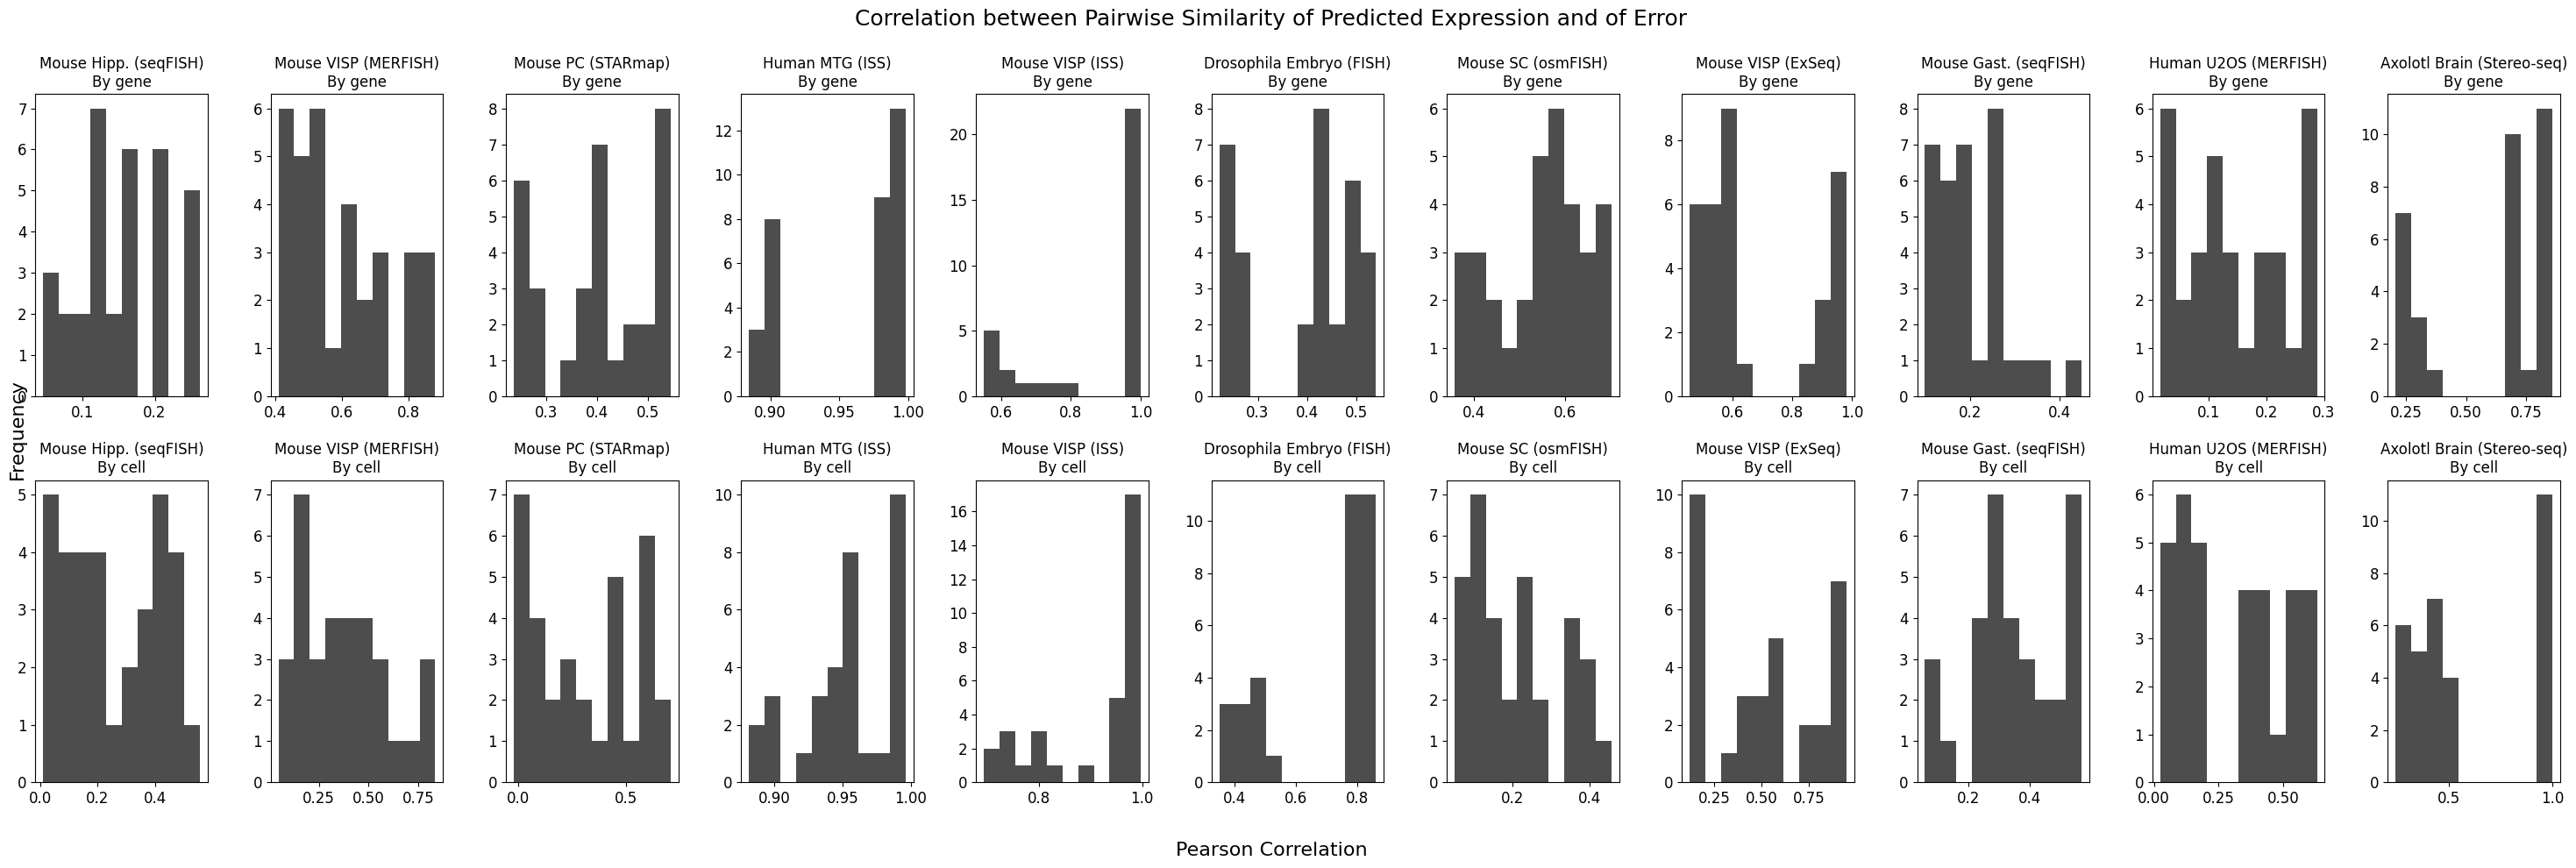

In [4]:
# Generate histogram plots of the correlation values
datasets = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17", "Dataset1", "Dataset7", "Axolotl"]

fig, axs = plt.subplots(2, len(datasets), sharex=False, sharey=False, figsize=(30, 10))

for i, mode in enumerate(["gene", "cell"]):
    for j, d in enumerate(datasets):
        
        if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad"):
            adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI.h5ad")
        else:
            adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_knn_spage_tangram_SCPI")
        
        # get correlation of pairwise similarities
        r_list = get_correlation_between_error_corr_and_expression_corr(adata, mode=mode)
        
        axs[i,j].set_title(f"{dataset_mapper[d]}\nBy {mode}")
        axs[i,j].tick_params(axis='both', which='major', labelsize=12)
        axs[i,j].tick_params(axis='both', which='minor', labelsize=12)
        
        axs[i,j].hist(r_list, bins=10, color="0.3")

fig.supxlabel("Pearson Correlation", fontsize=16)
fig.supylabel("Frequency", fontsize=16)
fig.suptitle("Correlation between Pairwise Similarity of Predicted Expression and of Error", fontsize=18)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_datasets/prediction_expn_error_correlation_of_correlations.pdf')
plt.show()